In [37]:
import pandas as pd
from torch.utils.data import Dataset

In [24]:
dataset = pd.read_csv('diganens.csv',index_col=0)

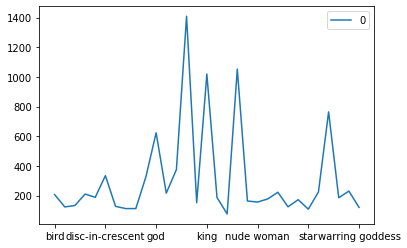

In [40]:
labels = dataset.drop(['Quelle', 'category'],axis=1,inplace=False).sum()
pd.DataFrame(labels)

In [53]:
labels = dataset[dataset.category == 'photo']
labels.drop('category',axis=1)

,Quelle,bird,bull,bull-man,crescent,cross,disc-in-crescent,dog,drill hole(s),fly,...,priest,rhomb,rosette,six-curled hero,star,sun-god,suppliant goddess,tree,vessel,warring goddess
imageID,,,,,,,,,,,,,,,,,,,,,
I000327,"Collon 1986,1.jpg",0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
I000328,"Collon 1986,2.jpg",0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
I000329,"Collon 1986,3.jpg",0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
I000330,"Collon 1986,4.jpg",0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I000331,"Collon 1986,5.jpg",0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
I002848,"Porada_Collon 2016,3K14.jpg",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
I002849,"Porada_Collon 2016,3K15.jpg",0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
I002850,"Porada_Collon 2016,3K16.jpg",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [39]:
class DiganesDataset(Dataset):
    """Diganses seals dataset."""

    def __init__(self, csv_file, root_dir, category=None, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            category (string, optional): Optional ilustration type, can be 'drawing' or 'photo'.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        labels = pd.read_csv(csv_file,index_col=0)
        
        #filter only specifc type of ilusration
        if category:
            labels = labels[labels.category == category]
        
        self.labels = labels.drop('category', axis=1)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.labels.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample